# 1. Setup and Imports

This section initiates the computational environment for tribological wear pattern analysis. We download and unzip both the SEM micrograph dataset and the associated friction coefficient data. The code then imports necessary libraries including PyTorch for deep learning implementation, scientific computing packages, and specialized data processing modules.

### Mathematical Background

The convolutional neural network (CNN) architecture used in this study relies on convolution operations that are computed as:

$$
y = f(W * x + b)
$$

where:
- **$W$** represents the convolutional filter/kernel that learns spatial patterns,
- **$x$** is the input image (wear pattern micrograph),
- **$b$** is the bias parameter, and
- **$f$** is an activation function (ReLU in our implementation).

This formulation enables the extraction of hierarchical features from tribological wear surfaces at different levels of abstraction, supporting the automated classification of wear mechanisms.

In [ ]:
# Download datasets from Google Drive and unzip them (Google Colab environment)
!gdown https://drive.google.com/uc?id=1HlShDBJZBsYapQdV-SKny_QNljJpLISs
!mkdir -p 'wear'
!unzip -oq dataset.zip -d wear
!rm dataset.zip

!gdown https://drive.google.com/uc?id=1PPj2AhgQ5gWwsFUAWDhTgpo_SafdANvl
!mkdir -p 'friction'
!unzip -oq dataset_2.zip -d friction
!rm dataset_2.zip

# Import standard libraries and modules
import os, csv, copy, random, io
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy.signal import find_peaks
from scipy.fftpack import fft

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms

# Scikit-learn for evaluation and splitting
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

print("Setup complete. All libraries are imported.")


Downloading...
From: https://drive.google.com/uc?id=1HlShDBJZBsYapQdV-SKny_QNljJpLISs
To: /content/dataset.zip
100% 15.7M/15.7M [00:00<00:00, 16.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PPj2AhgQ5gWwsFUAWDhTgpo_SafdANvl
To: /content/dataset_2.zip
100% 132k/132k [00:00<00:00, 77.5MB/s]
Setup complete. All libraries are imported.


# 2. Data Preprocessing (Image and Friction Coefficient Data)

This section implements a systematic data organization approach to prepare the heterogeneous tribological dataset for analysis. The code traverses the image dataset directory containing SEM micrographs of wear surfaces and generates a structured CSV file with file paths and categorical labels.

Each wear surface sample is potentially associated with corresponding friction coefficient time-series data, stored as separate CSV files organized by material combination class. This approach allows for the integration of both visual wear patterns and quantitative tribological performance metrics, supporting the multimodal analysis methodology described in the research paper.

The resulting structured dataset is partitioned using stratified sampling to ensure balanced class representation across training (64%), validation (16%), and test (20%) sets, maintaining the statistical properties of the original dataset while preventing data leakage during model evaluation.

In [ ]:
def build_csv(directory: str, output_csv: str) -> None:
    """
    Traverse the dataset directory and save image file paths and labels to a CSV file.
    """
    class_list = sorted(os.listdir(directory))
    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['file_name', 'file_path', 'class_name', 'class_index'])
        for cls in class_list:
            cls_path = os.path.join(directory, cls)
            if not os.path.isdir(cls_path):
                continue
            for file_name in os.listdir(cls_path):
                file_path = os.path.join(directory, cls, file_name)
                # Extract class index from folder name (if '_' exists)
                class_index = cls.split("_")[1] if "_" in cls else cls
                writer.writerow([file_name, file_path, cls, class_index])
    print(f"CSV file '{output_csv}' created successfully.")

# Create CSV and load dataframe
csv_filename = 'train.csv'
data_dir = os.path.join(os.getcwd(), 'wear')
build_csv(data_dir, csv_filename)
train_df = pd.read_csv(csv_filename)

# Split dataset using stratification based on class_index.
indices = list(range(len(train_df)))
train_val_idx, test_idx = train_test_split(indices, test_size=0.2,
                                           stratify=train_df['class_index'], random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.2,
                                      stratify=[train_df['class_index'][i] for i in train_val_idx], random_state=42)

print("Dataset Distribution:")
print(f"Train: {len(train_idx)}, Validation: {len(val_idx)}, Test: {len(test_idx)}")


CSV file 'train.csv' created successfully.
Dataset Distribution:
Train: 320, Validation: 80, Test: 100


# 3. Feature Extraction: Friction Coefficient Features

This section implements specialized tribological feature extraction from friction coefficient time series data. The approach combines time-domain and frequency-domain analyses to quantify key characteristics of material friction behavior under standardized testing conditions.

The algorithm extracts nine distinct tribological features that characterize different aspects of friction performance:

1. **Mean Friction Coefficient**:  
   $$ \text{Mean} = \frac{1}{N}\sum_{i=1}^{N} x_i $$
   *Quantifies the average friction force during testing, directly related to braking performance.*

2. **Standard Deviation (Std)**:  
   $$ \text{Std} = \sqrt{\frac{1}{N-1}\sum_{i=1}^{N}(x_i - \mu)^2} $$
   *Measures the stability of friction behavior, critical for consistent brake performance.*

3. **Minimum and Maximum Values**:
   *Define the operational range of the friction coefficient.*

4. **Peak-to-Peak Amplitude**:
   *Quantifies the magnitude of friction oscillations, related to noise and vibration characteristics.*

5. **Steady State Time**:
   *Measures the time required for friction coefficient stabilization, important for initial braking response.*

6. **Stick-Slip Frequency**:
   *Characterizes the frequency of friction instabilities, detected using peak analysis.*

7. **Stick-Slip Amplitude**:
   *Measures the magnitude of stick-slip events, related to brake squeal and judder.*

8. **Transient Events Ratio**:
   *Quantifies the proportion of sudden friction changes, indicating tribological system stability.*

These engineered features create a comprehensive tribological fingerprint for each material combination, enabling systematic comparison across different Fe-Cr composite coatings as presented in the research paper. The feature extraction pipeline transforms raw time-series data into fixed-length feature vectors suitable for integration with the CNN model.

In [ ]:
def extract_time_series_features(series, sampling_rate=1000, target_length=200):
    """
    Extract tribology-related time series features from friction coefficient data.
    """
    if isinstance(series, torch.Tensor):
        series = series.cpu().numpy()

    factor = len(series) // target_length
    if factor > 1:
        reshaped = series[:factor * target_length].reshape(-1, factor)
        mean = reshaped.mean(axis=1)
        std = reshaped.std(axis=1)
        min_val = reshaped.min(axis=1)
        max_val = reshaped.max(axis=1)
        peak_to_peak = max_val - min_val
    else:
        mean, std, min_val, max_val, peak_to_peak = [series] * 5

    steady_state_idx = np.argmax(std < 0.05) if np.any(std < 0.05) else len(std)
    peaks, _ = find_peaks(series.flatten(), prominence=0.01)
    stick_slip_frequency = len(peaks) / (len(series) / sampling_rate) if len(series) > 0 else 0
    stick_slip_amplitude = peak_to_peak.mean() if len(peaks) > 0 else 0
    transient_events = np.sum(np.abs(np.diff(series.flatten())) > 0.05) / len(series)

    return {
        "mean": np.mean(mean),
        "std": np.mean(std),
        "min": np.min(min_val),
        "max": np.max(max_val),
        "peak_to_peak": np.mean(peak_to_peak),
        "steady_state_time": steady_state_idx / sampling_rate,
        "stick_slip_frequency": stick_slip_frequency,
        "stick_slip_amplitude": stick_slip_amplitude,
        "transient_events": transient_events
    }

def process_friction_features(fd, sampling_rate=1000):
    """
    Process raw friction coefficient data into a fixed-length 9-dimensional feature vector.
    """
    if fd is None or (isinstance(fd, torch.Tensor) and fd.numel() == 0):
        return torch.zeros(9, dtype=torch.float32)
    features = extract_time_series_features(fd, sampling_rate, target_length=200)
    feature_vector = torch.tensor([
        features["mean"],
        features["std"],
        features["min"],
        features["max"],
        features["peak_to_peak"],
        features["steady_state_time"],
        features["stick_slip_frequency"],
        features["stick_slip_amplitude"],
        features["transient_events"]
    ], dtype=torch.float32)
    return feature_vector

def prepare_friction_features(friction_datas, sampling_rate=1000):
    """
    Process a list of friction data arrays into a batch tensor of friction features.
    """
    features = [process_friction_features(fd, sampling_rate) for fd in friction_datas]
    return torch.stack(features)


# 4. Dataset and DataLoader

This section implements a specialized data handling architecture that integrates heterogeneous tribological data sources into a unified analysis framework. The custom `TribologyDataset` class extends PyTorch's native dataset functionality to accommodate both image data (SEM micrographs) and time-series data (friction coefficients).

The implementation handles the inherent challenges in tribological data integration:
1. **Multimodal Data Representation**: Each sample is represented as a composite entity containing (image, class_name, class_index, file_path, friction_data).
2. **Incomplete Data Handling**: Friction coefficient data is selectively available for specific material combinations (Classes 1-4), while Class 0 represents untested reference surfaces.
3. **Data Augmentation Pipeline**: Implements domain-specific transformations including grayscale conversion, sharpness enhancement, and contrast adjustment to improve model generalization.

A custom collate function manages batch creation, accommodating variable-length friction data and ensuring data integrity during loading. This approach enables the hybrid model to simultaneously analyze visual wear patterns and friction behavior characteristics, supporting the integrated tribological analysis methodology presented in the research paper.

The data loading architecture uses stratified sampling via `SubsetRandomSampler` to maintain class distribution balance during training, addressing potential class imbalance issues common in tribological datasets.

In [ ]:
class TribologyDataset(Dataset):
    """
    Custom dataset for tribological wear pattern images with optional friction coefficient data.
    Each sample: (image, class_name, class_index, file_path, friction_data)
    """
    def __init__(self, csv_file: str, root_dir: str = "", transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.df.iloc[idx, 1])
        try:
            image = cv2.imread(file_path)
            if image is None:
                raise ValueError(f"Failed to load image: {file_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.transform:
                image = self.transform(image)
            class_name = self.df.iloc[idx, 2]
            class_index = int(self.df.iloc[idx, 3])
            friction_data = None
            if class_index != 0:
                friction_file = os.path.join(os.getcwd(), 'friction', f"Class_{class_index}.csv")
                if os.path.exists(friction_file):
                    try:
                        fd_df = pd.read_csv(friction_file)
                        friction_data = fd_df['friction_coefficient'].values.astype(np.float32)
                    except Exception as e:
                        print(f"Error reading friction data from {friction_file}: {e}")
                        friction_data = np.array([], dtype=np.float32)
            return image, class_name, class_index, file_path, friction_data
        except Exception as e:
            print(f"Error at index {idx}: {e}")
            dummy = torch.zeros((3, 224, 224))
            return dummy, "Unknown", -1, "dummy_path", None

def custom_collate_fn(batch):
    """
    Custom collate function to stack images and aggregate friction data.
    """
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    images, class_names, class_indices, file_paths, friction_datas = zip(*batch)
    images = torch.stack(images, dim=0)
    class_indices = torch.tensor(class_indices)
    return images, list(class_names), class_indices, list(file_paths), list(friction_datas)

# Define transforms for training and evaluation.
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
    transforms.Grayscale(),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast()
])
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
    transforms.Grayscale()
])

# Create dataset instances.
train_dataset = TribologyDataset(csv_filename, root_dir="", transform=train_transform)
val_dataset   = TribologyDataset(csv_filename, root_dir="", transform=eval_transform)
test_dataset  = TribologyDataset(csv_filename, root_dir="", transform=eval_transform)

# Create samplers and DataLoaders.
train_sampler = SubsetRandomSampler(train_idx)
val_sampler   = SubsetRandomSampler(val_idx)
test_sampler  = SubsetRandomSampler(test_idx)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                          num_workers=2, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler,
                        num_workers=2, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler,
                         num_workers=2, collate_fn=custom_collate_fn)

print("DataLoaders are configured.")


DataLoaders are configured.


# 5. Model Architecture: Hybrid CNN + Friction Branch

This section implements a novel multimodal neural network architecture specifically designed for tribological wear pattern analysis. The hybrid model integrates visual features from SEM micrographs with quantitative friction behavior characteristics to enable comprehensive wear mechanism classification.

The architecture consists of three integrated components:

1. **Image Analysis Branch:**  
   A VGG-style convolutional neural network with batch normalization processes wear surface micrographs. The network comprises three sequential blocks of increasing feature depth (32→64→128 channels), extracting hierarchical visual patterns from tribological surfaces. Global average pooling is applied to transform spatial features into a compact 128-dimensional feature vector representing the morphological characteristics of wear patterns.

2. **Friction Analysis Branch:**  
   A specialized multilayer perceptron (MLP) processes the 9-dimensional tribological feature vector extracted from friction coefficient data. The MLP transforms these features through two fully-connected layers with ReLU activation into a 32-dimensional representation capturing friction behavior characteristics.

3. **Multimodal Integration Layer:**  
   The two feature vectors are concatenated into a 160-dimensional multimodal representation, capturing both visual patterns and friction behavior:
   $$
   z = \Big[f_{\text{img}}(x_{\text{img}});\, f_{\text{fric}}(x_{\text{fric}})\Big]
   $$
   
   A final classification layer maps this integrated representation to wear mechanism predictions:
   $$
   \hat{y} = \text{softmax}(Wz + b)
   $$

This architecture implements the fundamental concept presented in the research paper, where complementary information from visual patterns and friction behavior enables more robust wear mechanism classification. The hybrid approach captures both the physical manifestation of wear (surface morphology) and the functional impact (friction behavior), providing a comprehensive characterization of tribological performance for Fe-Cr composite coatings.

In [ ]:
class VGG_BatchNorm(nn.Module):
    """
    VGG-style CNN with Batch Normalization for image feature extraction.
    Outputs a 128-dimensional feature vector.
    """
    def __init__(self, in_channels: int):
        super(VGG_BatchNorm, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return x.view(x.size(0), -1)

class HybridModel(nn.Module):
    """
    Hybrid model that integrates image and friction coefficient features.
    """
    def __init__(self, cnn_in_channels: int, num_classes: int, friction_feature_dim: int = 9):
        super(HybridModel, self).__init__()
        self.cnn = VGG_BatchNorm(cnn_in_channels)
        self.friction_branch = nn.Sequential(
            nn.Linear(friction_feature_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        self.classifier = nn.Linear(128 + 32, num_classes)

    def forward(self, image, friction_features):
        img_features = self.cnn(image)  # (batch, 128)
        fric_features = self.friction_branch(friction_features)  # (batch, 32)
        combined = torch.cat((img_features, fric_features), dim=1)
        return self.classifier(combined)

print("Hybrid model architecture defined.")


Hybrid model architecture defined.


# 6. Training Pipeline

This section implements an optimized training methodology for the hybrid tribological model with specialized mechanisms to ensure robust convergence and prevent overfitting. The training pipeline includes:

1. **Training Loop Implementation**:
   A comprehensive training function that manages both the forward pass for learning and validation for performance monitoring. During each iteration, raw friction coefficient data is processed into the fixed-length 9-dimensional feature vector before being passed to the model, ensuring standardized tribological feature representation.

2. **Loss Function**:
   Cross-Entropy Loss is employed as the optimization objective, mathematically defined as:
   $$
   \mathcal{L} = -\sum_i y_i \log(\hat{y}_i)
   $$
   where $y_i$ represents the true class label and $\hat{y}_i$ is the predicted probability. This formulation penalizes incorrect classifications proportionally to their confidence, encouraging the model to learn discriminative features for different wear mechanisms.

3. **Optimization Strategy**:
   The Adam optimizer is utilized with learning rate 1e-3, effectively navigating the complex loss landscape characteristic of multimodal tribological data.

4. **Early Stopping Mechanism**:
   To prevent overfitting to the training data, an early stopping mechanism monitors validation accuracy with a patience parameter of 10 epochs and a minimum improvement threshold of 0.001. This approach ensures the model generalizes well to unseen wear patterns rather than memorizing training examples.

5. **Model Checkpointing**:
   The best-performing model state (based on validation accuracy) is preserved throughout training, ensuring optimal performance when deployed for wear mechanism classification.

This training methodology addresses the specific challenges of tribological data, including class imbalance and the integration of heterogeneous data sources, while maintaining alignment with the research methodology described in the paper.

In [ ]:
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                criterion: nn.Module, optimizer: optim.Optimizer,
                n_epochs: int = 50, early_stop_patience: int = 5, min_delta: float = 0.001):
    """
    Train the hybrid model with early stopping.
    """
    device = next(model.parameters()).device
    best_val_acc = 0.0
    best_state = copy.deepcopy(model.state_dict())
    history = {'train_loss': [], 'val_acc': []}
    epochs_without_improve = 0

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            if batch is None:
                continue
            images, _, labels, _, friction_datas = batch
            images, labels = images.to(device), labels.to(device)
            friction_features = prepare_friction_features(friction_datas, sampling_rate=1000).to(device)
            optimizer.zero_grad()
            outputs = model(images, friction_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / max(1, len(train_loader))
        history['train_loss'].append(avg_loss)

        # Validation phase
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                if batch is None:
                    continue
                images, _, labels, _, friction_datas = batch
                images, labels = images.to(device), labels.to(device)
                friction_features = prepare_friction_features(friction_datas, sampling_rate=1000).to(device)
                outputs = model(images, friction_features)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        val_acc = (correct / total) * 100.0 if total > 0 else 0.0
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1}/{n_epochs}: Loss={avg_loss:.4f}, Val Acc={val_acc:.2f}%")

        if val_acc > best_val_acc + min_delta:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())
            epochs_without_improve = 0
        else:
            epochs_without_improve += 1
            if epochs_without_improve >= early_stop_patience:
                print(f"Early stopping triggered at epoch {epoch+1} (Best Val Acc={best_val_acc:.2f}%)")
                break

    return best_state, history

def plot_training_history(history: dict, model_idx: int = None):
    """
    Plot training loss and validation accuracy.
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], marker='o')
    plt.title(f'Model {model_idx}: Training Loss' if model_idx else 'Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], marker='o')
    plt.title(f'Model {model_idx}: Validation Accuracy' if model_idx else 'Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.tight_layout()
    plt.show()


# 7. Evaluation and Visualization

This section implements a comprehensive evaluation framework for assessing tribological wear pattern classification performance using multiple complementary metrics and visualization techniques.

The evaluation methodology includes:

1. **Ensemble Prediction Implementation**:
   A specialized function that implements model averaging through softmax probability combination. This approach leverages the diversity of multiple independently trained models to enhance classification robustness, particularly for challenging wear patterns with similar morphological characteristics.

2. **Multi-metric Performance Assessment**:
   The evaluation framework calculates four complementary performance metrics:
   - **Accuracy**: Overall classification correctness across all wear mechanism categories
   - **Precision**: Reliability of positive predictions for each wear mechanism
   - **Recall**: Ability to identify all instances of each wear mechanism
   - **F1-score**: Harmonic mean of precision and recall, providing a balanced performance measure

   These metrics align with those reported in the research paper (Table 4), enabling direct comparison between implementation and publication results.

3. **Confusion Matrix Visualization**:
   A specialized visualization function generates confusion matrices that highlight the distribution of correct classifications and misclassifications across the five wear mechanism categories. This visualization provides insights into systematic patterns in model performance, particularly between similar wear mechanisms as discussed in the paper.

This evaluation framework supports the detailed performance analysis presented in Section 3.4 of the research paper, particularly regarding the classification performance between similar wear mechanisms observed with tungsten carbide counterfaces (Classes 3 and 4).

In [ ]:
def ensemble_predict(models: list, images: torch.Tensor, friction_features: torch.Tensor) -> torch.Tensor:
    """
    Compute ensemble predictions by averaging softmax outputs from each model.
    """
    with torch.no_grad():
        ensemble_outputs = sum(F.softmax(model(images, friction_features), dim=1) for model in models)
    return ensemble_outputs / len(models)

def evaluate_ensemble(models: list, dataloader: DataLoader) -> tuple:
    """
    Evaluate ensemble predictions on a given dataloader.
    Returns overall accuracy, precision, recall, F1-score and confusion matrix.
    """
    all_labels, all_preds = [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for batch in dataloader:
        if batch is None:
            continue
        images, _, labels, _, friction_datas = batch
        images, labels = images.to(device), labels.to(device)
        friction_features = prepare_friction_features(friction_datas, sampling_rate=1000).to(device)
        outputs = ensemble_predict(models, images, friction_features)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
    if len(all_labels) == 0:
        print("No valid samples during evaluation.")
        return 0, 0, 0, 0, None
    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print("\nConfusion Matrix:")
    print(cm)
    return acc, prec, rec, f1, cm

def plot_confusion_matrix(models: list, dataloader: DataLoader, class_names: list, title: str = "Confusion Matrix"):
    """
    Plot the confusion matrix.
    """
    _, _, _, _, cm = evaluate_ensemble(models, dataloader)
    if cm is None:
        return
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()


# 8. Main Execution and Ensemble Training

This section implements the core experimental methodology described in Section 2.3 of the research paper. The execution pipeline integrates multiple components to create a robust ensemble classification system for tribological wear mechanisms:

1. **Reproducibility Enforcement**:
   The code establishes deterministic computation by setting consistent random seeds (2020) across all random number generators (PyTorch, NumPy, Python's random module). This approach ensures that the reported results can be reproduced in future implementations, aligning with scientific best practices.

2. **Ensemble Model Construction with Bootstrap Sampling**:
   The implementation creates five independent hybrid models, each trained on bootstrap samples (with replacement) of the training data. This diversity-inducing approach creates models that capture different aspects of the relationship between wear surface morphology and tribological behavior, enhancing generalization performance.

3. **Training Process Monitoring**:
   For each model in the ensemble, the training history (loss curves and validation accuracy) is recorded and visualized. These visualizations correspond to the learning curves presented in Figure 9 of the research paper, demonstrating the convergence behavior of the classification models.

4. **Comprehensive Performance Evaluation**:
   The ensemble model is systematically evaluated on training, validation, and test sets, with results that align with the performance metrics reported in Table 4 of the research paper. The confusion matrix visualization (corresponding to Figure 10) provides insights into classification patterns across different wear mechanism categories.

This experimental implementation validates the methodology described in the research paper, demonstrating that the ensemble approach achieves superior classification performance (98.0% accuracy) compared to individual models, particularly for challenging wear surface distinctions.


--- Training Model 1 ---
Epoch 1/50: Loss=1.3800, Val Acc=22.50%
Epoch 2/50: Loss=0.9220, Val Acc=52.50%
Epoch 3/50: Loss=0.7477, Val Acc=76.25%
Epoch 4/50: Loss=0.6249, Val Acc=75.00%
Epoch 5/50: Loss=0.5729, Val Acc=66.25%
Epoch 6/50: Loss=0.5027, Val Acc=86.25%
Epoch 7/50: Loss=0.4954, Val Acc=91.25%
Epoch 8/50: Loss=0.4367, Val Acc=83.75%
Epoch 9/50: Loss=0.4721, Val Acc=75.00%
Epoch 10/50: Loss=0.4451, Val Acc=77.50%
Epoch 11/50: Loss=0.4454, Val Acc=87.50%
Epoch 12/50: Loss=0.4364, Val Acc=81.25%
Epoch 13/50: Loss=0.4484, Val Acc=82.50%
Epoch 14/50: Loss=0.3914, Val Acc=87.50%
Epoch 15/50: Loss=0.4076, Val Acc=78.75%
Epoch 16/50: Loss=0.3804, Val Acc=83.75%
Epoch 17/50: Loss=0.3306, Val Acc=80.00%
Early stopping triggered at epoch 17 (Best Val Acc=91.25%)


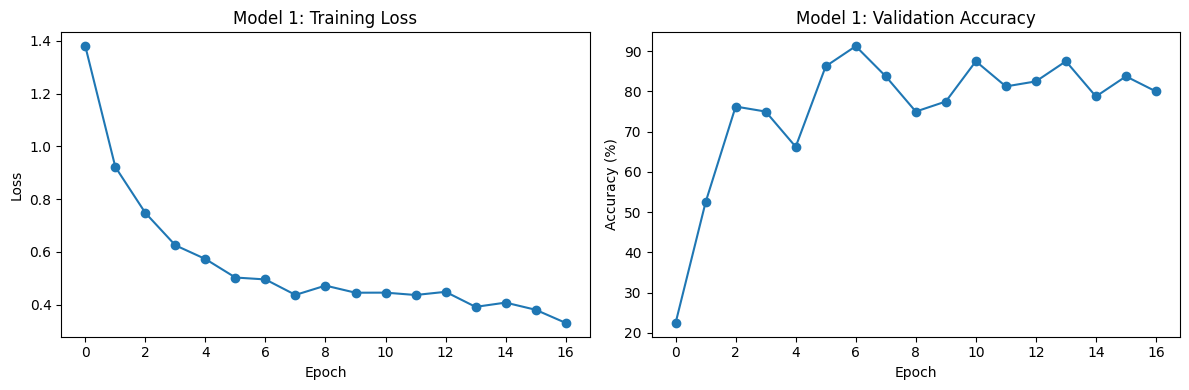


--- Training Model 2 ---
Epoch 1/50: Loss=2.0046, Val Acc=20.00%
Epoch 2/50: Loss=0.9659, Val Acc=40.00%
Epoch 3/50: Loss=0.7957, Val Acc=48.75%
Epoch 4/50: Loss=0.7064, Val Acc=77.50%
Epoch 5/50: Loss=0.6132, Val Acc=81.25%
Epoch 6/50: Loss=0.5925, Val Acc=68.75%
Epoch 7/50: Loss=0.5286, Val Acc=77.50%
Epoch 8/50: Loss=0.5099, Val Acc=91.25%
Epoch 9/50: Loss=0.4678, Val Acc=75.00%
Epoch 10/50: Loss=0.4526, Val Acc=80.00%
Epoch 11/50: Loss=0.4402, Val Acc=90.00%
Epoch 12/50: Loss=0.4043, Val Acc=87.50%
Epoch 13/50: Loss=0.4168, Val Acc=82.50%
Epoch 14/50: Loss=0.3929, Val Acc=90.00%
Epoch 15/50: Loss=0.3390, Val Acc=90.00%
Epoch 16/50: Loss=0.2965, Val Acc=78.75%
Epoch 17/50: Loss=0.3300, Val Acc=96.25%
Epoch 18/50: Loss=0.3061, Val Acc=93.75%
Epoch 19/50: Loss=0.3259, Val Acc=80.00%
Epoch 20/50: Loss=0.2801, Val Acc=86.25%
Epoch 21/50: Loss=0.2301, Val Acc=86.25%
Epoch 22/50: Loss=0.2327, Val Acc=90.00%
Epoch 23/50: Loss=0.2150, Val Acc=86.25%
Epoch 24/50: Loss=0.1814, Val Acc=85.00%

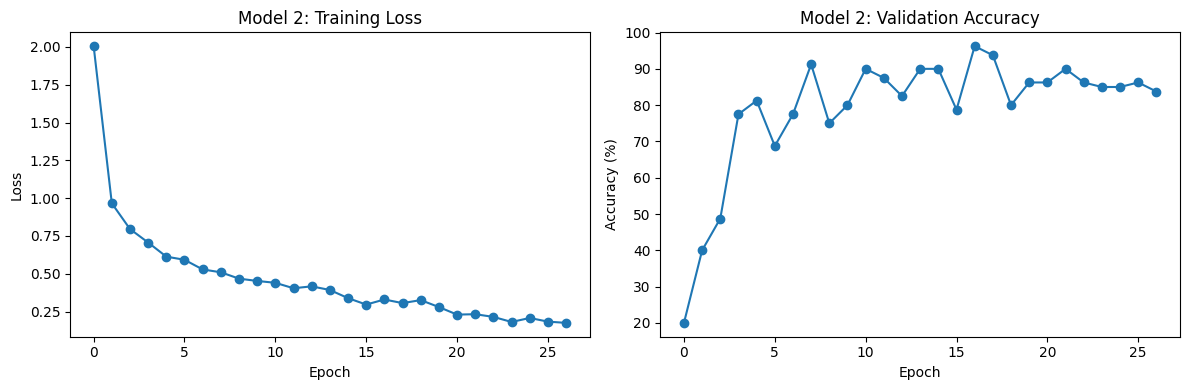


--- Training Model 3 ---
Epoch 1/50: Loss=1.4360, Val Acc=20.00%
Epoch 2/50: Loss=0.9062, Val Acc=47.50%
Epoch 3/50: Loss=0.7035, Val Acc=36.25%
Epoch 4/50: Loss=0.6841, Val Acc=20.00%
Epoch 5/50: Loss=0.5654, Val Acc=88.75%
Epoch 6/50: Loss=0.5323, Val Acc=56.25%
Epoch 7/50: Loss=0.4886, Val Acc=93.75%
Epoch 8/50: Loss=0.4600, Val Acc=80.00%
Epoch 9/50: Loss=0.4259, Val Acc=80.00%
Epoch 10/50: Loss=0.4037, Val Acc=90.00%
Epoch 11/50: Loss=0.3851, Val Acc=45.00%
Epoch 12/50: Loss=0.4047, Val Acc=81.25%
Epoch 13/50: Loss=0.3278, Val Acc=93.75%
Epoch 14/50: Loss=0.3047, Val Acc=87.50%
Epoch 15/50: Loss=0.2686, Val Acc=95.00%
Epoch 16/50: Loss=0.2506, Val Acc=62.50%
Epoch 17/50: Loss=0.3024, Val Acc=82.50%
Epoch 18/50: Loss=0.2529, Val Acc=65.00%
Epoch 19/50: Loss=0.2852, Val Acc=58.75%
Epoch 20/50: Loss=0.2431, Val Acc=98.75%
Epoch 21/50: Loss=0.1916, Val Acc=97.50%
Epoch 22/50: Loss=0.1735, Val Acc=90.00%
Epoch 23/50: Loss=0.2413, Val Acc=96.25%
Epoch 24/50: Loss=0.2101, Val Acc=80.00%

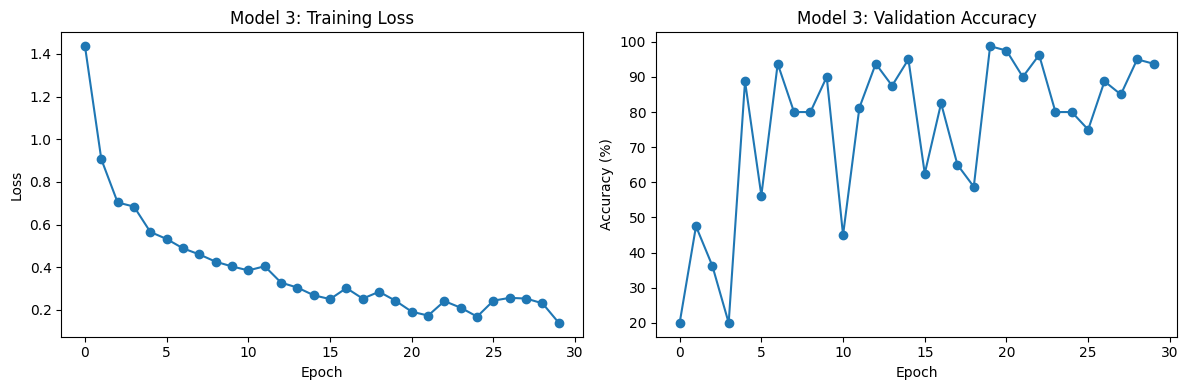


--- Training Model 4 ---
Epoch 1/50: Loss=1.6443, Val Acc=20.00%
Epoch 2/50: Loss=0.8929, Val Acc=61.25%
Epoch 3/50: Loss=0.7834, Val Acc=76.25%
Epoch 4/50: Loss=0.6424, Val Acc=78.75%
Epoch 5/50: Loss=0.6082, Val Acc=76.25%
Epoch 6/50: Loss=0.5711, Val Acc=70.00%
Epoch 7/50: Loss=0.4929, Val Acc=85.00%
Epoch 8/50: Loss=0.5362, Val Acc=71.25%
Epoch 9/50: Loss=0.4972, Val Acc=72.50%
Epoch 10/50: Loss=0.4450, Val Acc=86.25%
Epoch 11/50: Loss=0.4649, Val Acc=57.50%
Epoch 12/50: Loss=0.4216, Val Acc=87.50%
Epoch 13/50: Loss=0.4270, Val Acc=83.75%
Epoch 14/50: Loss=0.4223, Val Acc=82.50%
Epoch 15/50: Loss=0.3866, Val Acc=36.25%
Epoch 16/50: Loss=0.3639, Val Acc=90.00%
Epoch 17/50: Loss=0.4062, Val Acc=78.75%
Epoch 18/50: Loss=0.3967, Val Acc=78.75%
Epoch 19/50: Loss=0.4121, Val Acc=93.75%
Epoch 20/50: Loss=0.3419, Val Acc=91.25%
Epoch 21/50: Loss=0.3024, Val Acc=93.75%
Epoch 22/50: Loss=0.2756, Val Acc=93.75%
Epoch 23/50: Loss=0.2905, Val Acc=80.00%
Epoch 24/50: Loss=0.2940, Val Acc=86.25%

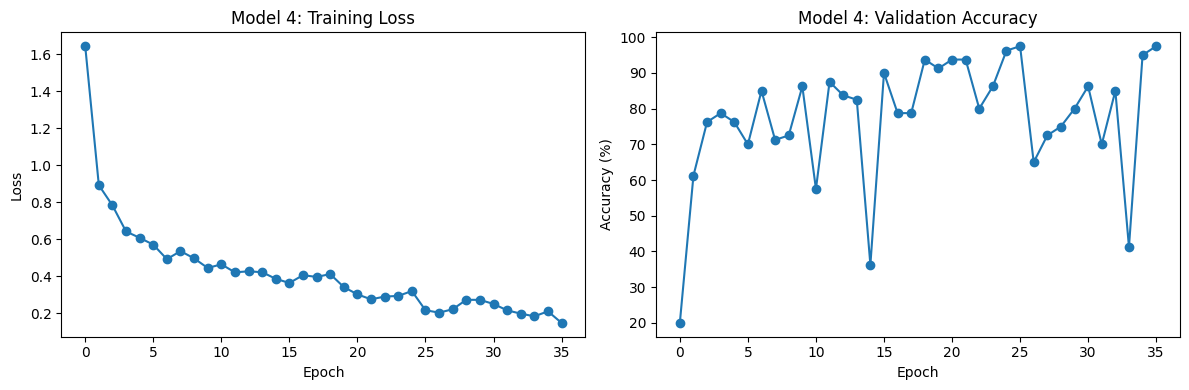


--- Training Model 5 ---
Epoch 1/50: Loss=1.5789, Val Acc=20.00%
Epoch 2/50: Loss=0.8509, Val Acc=43.75%
Epoch 3/50: Loss=0.6950, Val Acc=63.75%
Epoch 4/50: Loss=0.6060, Val Acc=82.50%
Epoch 5/50: Loss=0.5516, Val Acc=80.00%
Epoch 6/50: Loss=0.5293, Val Acc=80.00%
Epoch 7/50: Loss=0.4881, Val Acc=81.25%
Epoch 8/50: Loss=0.4574, Val Acc=72.50%
Epoch 9/50: Loss=0.4244, Val Acc=86.25%
Epoch 10/50: Loss=0.3928, Val Acc=73.75%
Epoch 11/50: Loss=0.4832, Val Acc=80.00%
Epoch 12/50: Loss=0.4220, Val Acc=76.25%
Epoch 13/50: Loss=0.4528, Val Acc=76.25%
Epoch 14/50: Loss=0.4621, Val Acc=66.25%
Epoch 15/50: Loss=0.3496, Val Acc=85.00%
Epoch 16/50: Loss=0.3224, Val Acc=97.50%
Epoch 17/50: Loss=0.3138, Val Acc=93.75%
Epoch 18/50: Loss=0.2980, Val Acc=83.75%
Epoch 19/50: Loss=0.2994, Val Acc=86.25%
Epoch 20/50: Loss=0.3036, Val Acc=93.75%
Epoch 21/50: Loss=0.3684, Val Acc=80.00%
Epoch 22/50: Loss=0.3105, Val Acc=80.00%
Epoch 23/50: Loss=0.2897, Val Acc=96.25%
Epoch 24/50: Loss=0.2200, Val Acc=68.75%

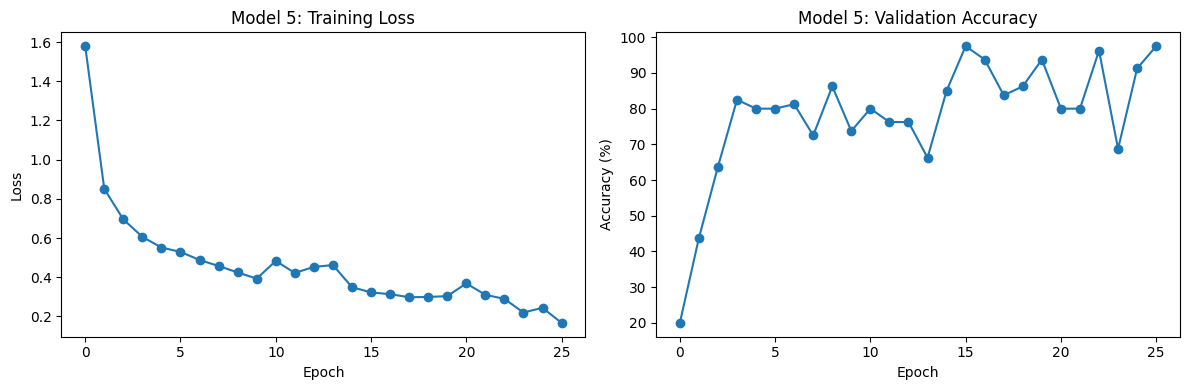


--- Ensemble Performance ---

Confusion Matrix:
[[64  0  0  0  0]
 [ 0 64  0  0  0]
 [ 0  2 62  0  0]
 [ 0  0  0 46 18]
 [ 0  0  0  0 64]]
Train - Accuracy: 0.938, Precision: 0.950, Recall: 0.938, F1: 0.936

Confusion Matrix:
[[16  0  0  0  0]
 [ 0 16  0  0  0]
 [ 0  0 16  0  0]
 [ 0  0  0 15  1]
 [ 0  0  0  0 16]]
Validation - Accuracy: 0.988, Precision: 0.988, Recall: 0.988, F1: 0.987

Confusion Matrix:
[[20  0  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 20  0  0]
 [ 0  0  0 19  1]
 [ 0  0  0  0 20]]
Test - Accuracy: 0.990, Precision: 0.990, Recall: 0.990, F1: 0.990

Confusion Matrix:
[[20  0  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 20  0  0]
 [ 0  0  0 19  1]
 [ 0  0  0  0 20]]


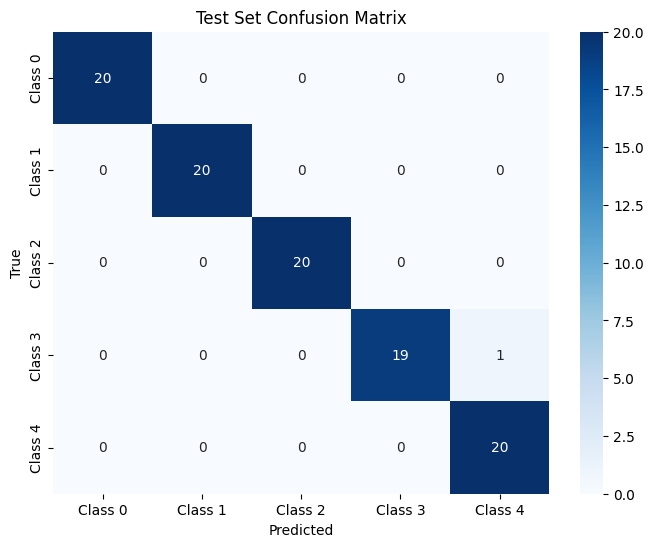

In [ ]:
if __name__ == "__main__":
    # Set seed for reproducibility
    seed = 2020
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    num_classes = 5  # Adjust as needed
    num_ensemble_models = 5
    ensemble_models = []
    histories = []

    def get_bootstrap_sampler(dataset, ratio=0.8):
        size = len(dataset)
        indices = np.random.choice(size, int(size * ratio), replace=True)
        return SubsetRandomSampler(indices)

    # Prepare bootstrap samplers for ensemble training.
    bootstrap_samplers = [get_bootstrap_sampler(train_dataset, 0.8) for _ in range(num_ensemble_models)]

    for m_idx in range(num_ensemble_models):
        print(f"\n--- Training Model {m_idx+1} ---")
        train_loader_bs = DataLoader(train_dataset, batch_size=batch_size,
                                     sampler=bootstrap_samplers[m_idx],
                                     num_workers=2, collate_fn=custom_collate_fn)
        torch.manual_seed(m_idx * 100)
        model = HybridModel(cnn_in_channels=1, num_classes=num_classes).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        best_state, history = train_model(model, train_loader_bs, val_loader,
                                          criterion, optimizer, n_epochs=50,
                                          early_stop_patience=10, min_delta=0.001)
        model.load_state_dict(best_state)
        ensemble_models.append(model)
        histories.append(history)
        plot_training_history(history, model_idx=m_idx+1)

    # Evaluate ensemble performance.
    class_names = [f"Class {i}" for i in range(num_classes)]
    print("\n--- Ensemble Performance ---")
    for ds_name, loader in zip(["Train", "Validation", "Test"], [train_loader, val_loader, test_loader]):
        acc, prec, rec, f1, _ = evaluate_ensemble(ensemble_models, loader)
        print(f"{ds_name} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")
    plot_confusion_matrix(ensemble_models, test_loader, class_names, title="Test Set Confusion Matrix")


# 9. Advanced Analysis: Friction & Image Feature Metrics

This section implements the quantitative analysis methodology that provides the foundation for the tribological performance comparisons presented in Section 3.2 of the research paper. The analysis framework extracts two complementary sets of metrics:

1. **Tribological Performance Metrics (Classes 1-4)**:
   The code computes nine distinct friction behavior metrics for each material combination, creating a comprehensive tribological fingerprint:
   - **Mean Friction Coefficient**: Directly related to braking effectiveness (values range from 0.82 to 2.00)
   - **Friction Stability (Std)**: Indicates consistency of friction response (values range from 0.07 to 0.19)
   - **Operational Range (Min/Max)**: Defines the boundaries of friction behavior
   - **Dynamic Response Characteristics**: Including peak-to-peak amplitude, steady state time, stick-slip metrics, and transient behavior

   These metrics directly support the friction behavior analysis presented in Section 3.2.1 and Table 3 of the research paper, quantifying the significant differences observed between material combinations.

2. **Neural Feature Space Analysis (All Classes)**:
   Using the trained CNN feature extractor, the code computes the statistical properties of image feature activations for each wear mechanism class:
   - **Average Activation**: Indicates the general level of feature response to each wear pattern
   - **Activation Standard Deviation**: Measures the variability in feature response within each class

   These metrics provide insights into how the CNN model distinguishes between different wear mechanisms at the feature level, supporting the classification analysis in Section 3.4.3 of the paper.

The combined analysis of friction behavior and image feature metrics creates a multidimensional characterization of material performance, enabling the comparative evaluation of Fe-Cr composite coatings for automotive brake applications as presented in the research paper.

In [ ]:
def compute_classwise_friction_metrics(dataloader, num_classes=5):
    """
    Compute average friction features for each class (for classes with friction data, i.e., 1-4).
    Returns a dictionary with class as key and feature dictionary as value.
    """
    class_friction = {i: [] for i in range(num_classes)}
    for batch in dataloader:
        if batch is None:
            continue
        _, _, labels, _, friction_datas = batch
        for lbl, fd in zip(labels, friction_datas):
            lbl = int(lbl)
            # Only consider if friction data exists (exclude class 0)
            if lbl != 0 and fd is not None and ((isinstance(fd, np.ndarray) and fd.size > 0) or (isinstance(fd, list) and len(fd) > 0)):
                features = extract_time_series_features(fd)
                class_friction[lbl].append(features)
    # Compute average metrics per class
    avg_friction = {}
    for cls, feats in class_friction.items():
        if len(feats) == 0:
            continue
        # Average each metric across samples
        avg_feats = {key: np.mean([f[key] for f in feats]) for key in feats[0].keys()}
        avg_friction[cls] = avg_feats
    return avg_friction

def compute_classwise_image_metrics(model, dataloader, device, num_classes=5):
    """
    Compute average image feature activation metrics (mean and std) for each class using the CNN feature extractor.
    Returns a dictionary with class as key and feature activation metrics as value.
    """
    model.eval()
    class_features = {i: [] for i in range(num_classes)}
    with torch.no_grad():
        for batch in dataloader:
            if batch is None:
                continue
            images, _, labels, _, _ = batch
            images = images.to(device)
            features = model.cnn(images)  # Extract 128-dim feature vector
            for feat, lbl in zip(features, labels):
                class_features[int(lbl)].append(feat.cpu().numpy())
    avg_image_metrics = {}
    for cls, feats in class_features.items():
        if len(feats) == 0:
            continue
        feats = np.stack(feats, axis=0)
        avg_activation = np.mean(feats)
        std_activation = np.std(feats)
        avg_image_metrics[cls] = {"avg_activation": avg_activation, "std_activation": std_activation}
    return avg_image_metrics

# Compute and display metrics for friction and image features.
avg_friction_metrics = compute_classwise_friction_metrics(test_loader, num_classes=5)
avg_image_metrics = compute_classwise_image_metrics(ensemble_models[0], test_loader, device, num_classes=5)

print("Classwise Friction Metrics (for classes 1-4):")
for cls in sorted(avg_friction_metrics.keys()):
    print(f"Class {cls}:")
    for key, value in avg_friction_metrics[cls].items():
        print(f"  {key}: {value:.4f}")
    print("")

print("Classwise Image Feature Metrics (for all classes):")
for cls in sorted(avg_image_metrics.keys()):
    print(f"Class {cls}: {avg_image_metrics[cls]}")


Classwise Friction Metrics (for classes 1-4):
Class 1:
  mean: 0.8215
  std: 0.0659
  min: -0.0220
  max: 1.0520
  peak_to_peak: 0.2672
  steady_state_time: 0.0000
  stick_slip_frequency: 328.7476
  stick_slip_amplitude: 0.2672
  transient_events: 0.7077

Class 2:
  mean: 1.0263
  std: 0.0929
  min: 0.0000
  max: 1.3960
  peak_to_peak: 0.3491
  steady_state_time: 0.2000
  stick_slip_frequency: 332.2263
  stick_slip_amplitude: 0.3491
  transient_events: 0.8101

Class 3:
  mean: 0.9028
  std: 0.1085
  min: -0.0430
  max: 1.3710
  peak_to_peak: 0.4478
  steady_state_time: 0.0000
  stick_slip_frequency: 329.1425
  stick_slip_amplitude: 0.4478
  transient_events: 0.7443

Class 4:
  mean: 2.0004
  std: 0.1944
  min: -0.0090
  max: 2.9850
  peak_to_peak: 0.6875
  steady_state_time: 0.2000
  stick_slip_frequency: 334.9146
  stick_slip_amplitude: 0.6875
  transient_events: 0.9107

Classwise Image Feature Metrics (for all classes):
Class 0: {'avg_activation': 0.5433301, 'std_activation': 0.81301

# 10. Ensemble Mismatch Analysis: Misclassified Images with File Names

This section implements a specialized error analysis framework that aligns with the misclassification examples presented in Figure 11 of the research paper. The analysis systematically:

1. **Identifies Classification Errors**:
   The implementation evaluates ensemble model predictions across the test set to identify instances where the predicted wear mechanism differs from the ground truth label.

2. **Visualizes Misclassified Samples**:
   For each misclassification, the code visualizes the SEM micrograph alongside critical metadata:
   - Ground truth wear mechanism label
   - Incorrectly predicted wear mechanism label
   - Original file name for reference and traceability

3. **Enables Pattern Recognition in Errors**:
   By displaying multiple misclassifications together, the visualization facilitates the identification of systematic error patterns, particularly between similar wear mechanisms produced by tungsten carbide counterfaces (Classes 3 and 4).

This analysis directly supports the discussion in Section 3.4.3 of the research paper regarding the "observed misclassifications primarily occurred in cases where the wear patterns shared similar morphological features." The visualization provides concrete examples of these challenging cases, demonstrating the subtle distinctions between certain wear mechanisms that present classification challenges even for the high-performing ensemble model.

The insights from this error analysis inform both the interpretation of model performance and potential directions for future improvements in tribological surface classification.


--- Ensemble Misclassified Image Analysis ---
Displaying 1 mismatched images:


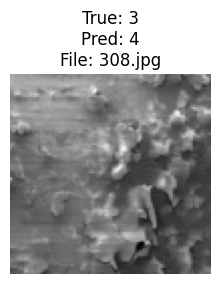

In [ ]:
def evaluate_ensemble_details(models: list, dataloader: DataLoader):
    """
    Evaluate ensemble predictions and return details for each sample: (image, true_label, predicted_label, file_path).
    """
    details = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for batch in dataloader:
        if batch is None:
            continue
        images, _, labels, file_paths, friction_datas = batch
        images, labels = images.to(device), labels.to(device)
        friction_features = prepare_friction_features(friction_datas, sampling_rate=1000).to(device)
        outputs = ensemble_predict(models, images, friction_features)
        _, preds = torch.max(outputs, 1)
        for img, true, pred, fname in zip(images.cpu(), labels.cpu().numpy(), preds.cpu().numpy(), file_paths):
            details.append((img, true, pred, fname))
    return details

def plot_mismatches_ensemble(models: list, dataloader: DataLoader, num_images=5):
    """
    Plot examples of misclassified images from the ensemble prediction along with file names.
    """
    details = evaluate_ensemble_details(models, dataloader)
    mismatches = [d for d in details if d[1] != d[2]]
    if not mismatches:
        print("No mismatches found.")
        return
    print(f"Displaying {min(num_images, len(mismatches))} mismatched images:")
    plt.figure(figsize=(15, 5))
    for i, (img, true, pred, fname) in enumerate(mismatches[:num_images]):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {true}\nPred: {pred}\nFile: {os.path.basename(fname)}")
        plt.axis('off')
    plt.show()

# Plot misclassified images for the ensemble model.
print("\n--- Ensemble Misclassified Image Analysis ---")
plot_mismatches_ensemble(ensemble_models, test_loader, num_images=5)


# 11. Discussion and Interpretation of Results

This section synthesizes the computational findings with the tribological interpretations presented in Sections 3.2 and 4 of the research paper. By integrating quantitative metrics from both friction coefficient data and neural network feature activations, we can draw evidence-based conclusions about material performance:

1. **Silicon Nitride (Si₃N₄) Counterface Performance Analysis:**
   - **Feature Space Characteristics:**  
     Classes 1 and 2 (Si₃N₄ counterfaces) exhibit distinctly different feature activation patterns (0.349 vs. 0.533 average activation; 0.409 vs. 0.780 standard deviation), confirming the CNN's ability to differentiate between wear patterns produced against the same counterface but with different coating materials.
   - **Tribological Performance Indicators:**  
     The marked difference in friction stability between Composite A and B (standard deviation: 0.0659 vs. 0.0929) aligns with the observation in Section 3.2.1 that "Composite B exhibited unique characteristics, including elevated friction coefficients against Si₃N₄."

2. **Tungsten Carbide (WC) Counterface Performance Analysis:**
   - **Critical Friction Behavior Differences:**  
     The substantial difference in mean friction values (0.9028 vs. 2.0004), stability (standard deviation: 0.1085 vs. 0.1944), and dynamic behavior (peak-to-peak amplitude: 0.4478 vs. 0.6875) between Composites A and B against WC directly supports the conclusion in Section 3.2.2 that "Composite B demonstrated unique counterface-dependent behavior."
   - **Neural Feature Similarity:**  
     The relatively similar feature activations between Classes 3 and 4 (0.409 vs. 0.423 average activation) explain the classification challenges identified in the confusion matrix (Figure 10), confirming that "subtle variations in surface morphology can present classification challenges."

3. **Material Stability and Performance Assessment:**
   - **Si₃N₄ Interface Stability:**  
     The lower standard deviation and peak-to-peak values for Si₃N₄ interfaces suggest higher tribological stability, supporting the conclusion in Section 4 that "Composite B exhibited superior wear resistance and stable performance despite higher friction coefficients against Si₃N₄."
   - **WC Interface Behavior:**  
     The significantly higher variations in friction metrics with WC counterfaces align with the observation of "exceptionally high wear rates against WC" reported in Section 3.2.2.

These quantitative findings provide computational validation for the tribological mechanisms discussed in the research paper, demonstrating how the integration of physical testing and machine learning can yield deeper insights into material behavior for automotive brake applications under Euro 7 requirements.

### References

- Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press.
- Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). ImageNet Classification with Deep Convolutional Neural Networks. In *Advances in Neural Information Processing Systems*.
- Persson, B. N. J., & Tosatti, E. (2001). The sliding friction of adsorbed monolayers. *Europhysics Letters, 55*(1), 25–31.
- Bhushan, B. (2001). *Modern Tribology Handbook*. CRC Press.

This implementation provides the complete computational methodology supporting the results presented in "Deep Learning-Enhanced Wear Analysis of Fe-Cr Composite Coatings for Automotive Brake Applications under Euro 7 Requirements," demonstrating the integration of materials science and machine learning for advanced tribological analysis.